# Medical Care on the Intensive Margin

In [1]:
from time import time

import matplotlib.pyplot as plt
import numpy as np

from HARK.ConsumptionSaving.ConsMedModel import MedShockConsumerType
from HARK.rewards import CRRAutility_inv

In [2]:
mystr = lambda number: f"{number:.4f}"
do_simulation = True

The foundational `IndShockConsumerType` lays out the standard permanent-transitory income shock structure, and the `GenIncomeProcessConsumerType` extends this to more generalized income dynamics. Extending the latter model further, `MedShockConsumerType` represents agents who make consumption-saving decisions subject to income risk (with one risk-free asset), and who also have a *second* consumption good that can represent medical care. Unlike ordinary consumption, medical care is subject to iid *medical need shocks*, representing a marginal utility shifter for medical care.

## Medical Need Shocks Model

The agent's problem can be written in Bellman form as:

\begin{eqnarray*}
V_t(M_t,P_t,\eta_t) &=& \max_{C_t, H_t} U(C_t, H_t; \eta_t) + \beta (1-\mathsf{D}_{t}) \mathbb{E} [V_{t+1}(M_{t+1}, P_{t+1}, \eta_{t+1})], \\
A_t &=& M_t - C_t - \pi_t H_t, \\
A_t &\geq& \underline{A} P_t, \\
M_{t+1} &=& R_{t+1} A_t + Y_{t+1}, \\
Y_{t+1} &=& P_{t+1} \theta_{t+1}, \\
P_{t+1} &=& \gimel_{t+1}(P_t)\psi_{t+1}, \\
\eta_{t} &\sim& G_{t},\\
(\psi_t,\theta_t) &\sim& F_t, \qquad\mathbb{E} [\psi_t] = 1, \\
U(C, H; \eta) &=& \frac{C^{1-\rho}}{1-\rho} + \eta \frac{H^{1-\nu}}{1-\nu}.
\end{eqnarray*}

The agent's state at the moment they make their choice of action is characterized by their level of market resources $M_t$, their permanent (or persistent) income level $P_t$, and their medical needs shock $\eta_t \geq 0$. They choose their levels of ordinary consumption $C_t$ and medical care $H_t$ (mnemonic: health care) to maximize their utility today plus expected discounted future value.

Utility flow is the sum of two CRRA terms with different coefficients, $\rho$ for consumption and $\nu$ for medical care. The medical care term is multiplied by $\eta_t$, so medical care is only purchased when $\eta_t > 0$. As a parameter restriction, we must have $\nu > 1$ so that the medical needs shock $\eta_t$ is *bad* for the agent and needs to be ameliorated through medical care.

Consumption is the implicit numeraire, and medical care has relative price $\pi_t$. The agent is constrained by some lower bound on how much they can borrow relative to their permanent income (often zero), and retained assets accumulate interest at risk free factor $R$.

Each period, the persistent component of income is altered by some expected growth function $\gimel$ (e.g. a log-linear function for an AR(1)), and subject to mean one shocks. Income flow itself is also subject to a transitory shock $\theta$, drawn jointly with permanent shock $\psi$. Medical need shocks $\eta$ are drawn from some distribution $G$, and the agent dies between periods with probability $\mathsf{D}_{t}$.

## Solving the Medical Needs Shock Model

Like most other models in HARK, this problem can be solved using the endogenous grid method (EGM). As usual, define the end-of-period (marginal) value function as:

\begin{eqnarray*}
\mathfrak{V}_t(A_t,P_t) &=& \beta (1-\mathsf{D}_{t}) \mathbb{E} [V_{t+1}(R_{t+1} A_t + \theta_{t+1}, ~~\gimel_{t+1}(P_t)\psi_{t+1}, \eta_{t+1})], \\
\mathfrak{V}^A_t(A_t,P_t) &=& \beta R_{t+1} (1-\mathsf{D}_{t}) \mathbb{E} [V^M_{t+1}(R_{t+1} A_t + \theta_{t+1}, ~~\gimel_{t+1}(P_t)\psi_{t+1}, \eta_{t+1})].
\end{eqnarray*}

Substituting the first equation into the Bellman form of the model definition, we have:

\begin{eqnarray*}
V_t(M_t,P_t,\eta_t) &=& \max_{C_t, H_t} \frac{C^{1-\rho}}{1-\rho} + \eta \frac{H^{1-\nu}}{1-\nu} + \mathfrak{V}_t(A_t,P_t), \\
A_t &=& M_t - C_t - \pi_t H_t, \\
A_t &\geq& \underline{a} P_t, \\
\eta_{t} &\sim& G_{t},\\
(\psi_t,\theta_t) &\sim& F_t, \qquad\mathbb{E} [\psi_t] = 1. \\
\end{eqnarray*}

This has two first order conditions for optimality, momentarily assuming an interior solution:

\begin{eqnarray*}
\text{FOC-C:} ~~ & C_t^{-\rho} - \mathfrak{V}^A_t(A_t,P_t) = 0, \\
\text{FOC-H:} ~~ & \eta_t H_t^{-\nu} - \pi_t \mathfrak{V}^A_t(A_t,P_t) = 0. \\
\end{eqnarray*}

Rearranging the FOCs yields simple forms for $C_t$ and $H_t$ from the end-of-period state $(A_t, P_t)$:

\begin{eqnarray*}
C_t &=& \mathfrak{V}^A_t(A_t,P_t)^{-1/\rho}, \\
H_t &=& \left( \frac{\pi_t}{\eta_t} \mathfrak{V}^A_t(A_t,P_t) \right)^{-1/\nu} = \left( \frac{\pi_t}{\eta_t}\right)^{-1/\nu} C_t^{\rho/\nu}.\\
\end{eqnarray*}

Inverting the intraperiod budget constraint, we can easily recover the endogenous $M_t$ gridpoint from which these optimal interior controls must have been chosen:

\begin{equation*}
M_t = A_t + C_t + \pi_t H_t.
\end{equation*}

Notice that when computing end-of-period marginal value of assets $A_t$, the current period's $\eta_t$ is irrelevant-- it's a "transitory state variable" that matters at decision-time but not beyond, because its draws are not serially correlated. Thus the same computation of $\mathfrak{V}^A_t(A_t,P_t)$ can be used for *all* values of interest for $\eta_t$. Very convenient!

The envelope condition in this model follows the usual logic of other consumption-saving models in HARK. If an agent was consuming at an optimal unconstrained solution, and they received a marginal dollar, they are indifferent between its allocation between $A_t$, $C_t$, and $H_t$ (because they were satisfying the FOCs). Hence the *marginal value* of market resources $M_t$ is the composition of the marginal utility (of consumption) function with the consumption function-- the agent "might as well" allocate the marginal dollar to consumption because they get the same marginal value for any choice.

The preceding logic suggests the following general algorithm for solving one period of the medical need shocks model:

1. Choose relevant grids of $P_t$ and $A_t$; it's wise to allow the the $A_t$ grid to vary by $P_t$.
2. Choose an appropriate discretized grid of $\eta_t$, along with probability masses.
3. Evaluate $\mathfrak{V}^A_t(A_t,P_t)$ at each end-of-state gridpoint.
4. Calculate solutions for $C_t$ and $H_t$ using the equations above, combining $(A_t,P_t)$ with the medical needs shock $\eta_t$
5. Recover the endogenous $M_t$ gridpoint for each end-of-period state -- medical needs shock combination.
6. Construct interpolations of $C_t$ and $H_t$ over $M_t$ for each $(P_t, \eta_t)$ pair.
7. Make a representation of the marginal value function as the composition of the marginal utility function and consumption function.
8. Choose a **new** exogenous grid of $M_t$ for each $P_t$.
9. Compute expectation of marginal value over $\eta_t$ for each $(M_t,P_t)$ pair.
10. Build an interpolated representation of the "expected marginal value" function, using the "pseudo-inverse" method.

## Solution When Liquidity Constrained and Representation of the Policy Function

The `solve_one_period_ConsMedShock` function uses this algorithm in broad strokes, but an observant reader might note that we haven't addressed the *liquidity constrained* portion of the state space. In models with only one control variable ($C_t$), this is trivial: if the agent is ending the period with the minimum allowable assets, then it *must* be that they spent all allowable market resources on consumption. In the basic case with a no-borrowing constraint, $A_t \geq 0$, being liquidity constrained means that $C_t = M_t$.

In this model, however, there are *two* controls, $C_t$ and $H_t$. When liquidity constrained, *total expenditure* $X_t \equiv C_t + \pi_t H_t$ must exhaust all available market resources, but that doesn't tell us *how* to split them between the two goods.

We already have a *characterization* of the liquidity constrained solution: the *intratemporal* FOC derived above that links optimal medical care to optimal consumption:

\begin{equation*}
H_t = \left( \frac{\pi_t}{\eta_t}\right)^{-1/\nu} C_t^{\rho/\nu}.
\end{equation*}

This condition must hold at *all* points on the solution. It says that the marginal utility of a dollar spent on consumption must equal the marginal utility of a dollar spent on medical care, else the agent could reallocate and improve their outcome.

(The following math and narrative is adapted from Appendix B.1 of "Heterogeneity in Willingness to Pay for Health Insurance Reform" by Khwaja and White, but most of the method there is based on the one that was originally developed for this model in HARK.)

Combining the definition of total expenditure $X_t$ and the intratemporal FOC yields a system of two equations with two unknowns (if we treat $X_t$ as a "variable constant" whose value is known). The system has no closed form solution for $(C_t,H_t)$, but that doesn't mean we need to conduct a numeric search to solve the constrained portion of the policy function. Let's instead do some semi-clever math, starting by substituting the intratemporal FOC into the definition of expenditure (and dropping the $t$ subscript):

\begin{equation*}
X = C + \pi \left( \frac{\pi}{\eta}\right)^{-1/\nu} C^{\rho/\nu} = C + \pi^{1-1/\nu} \eta^{1/\nu} C^{\rho/\nu}.
\end{equation*}

Next (and you'll just have to take a leap of faith with me here), we'll define consumption's "logit share" of expenditure as:

\begin{equation*}
Q \equiv -\log \left( \frac{X}{C} - 1\right) \Longleftrightarrow C = \frac{X}{1 + \exp(-Q)}.
\end{equation*}

This is just a change of variables whose purpose will become apparent soon enough.

Now substitute the $Q$-based definition of $C$ into our combined system equation above:

\begin{equation*}
X = \frac{X}{1 + \exp(-Q)} + \pi^{1-1/\nu} \eta^{1/\nu} \left( \frac{X}{1 + \exp(-Q)} \right)^{\rho/\nu}.
\end{equation*}

Move the first term of the RHS over to the LHS and combine the terms under a common denominator:

\begin{equation*}
\frac{X \exp(-Q)}{1 + \exp(-Q)} = \pi^{1-1/\nu} \eta^{1/\nu} \left( \frac{1}{1 + \exp(-Q)} \right)^{\rho/\nu} X^{\rho/\nu}.
\end{equation*}

Then divide the equation by $X$:

\begin{equation*}
\frac{\exp(-Q)}{1 + \exp(-Q)} = \pi^{1-1/\nu} \eta^{1/\nu} \left( \frac{1}{1 + \exp(-Q)} \right)^{\rho/\nu} X^{\rho/\nu - 1}.
\end{equation*}

Take the logarithm of both sides:

\begin{equation*}
-Q - \log(1 + \exp(-Q)) = \left(1 - \frac{1}{\nu} \right) \log(\pi) + \frac{1}{\nu} \log (\eta) - \frac{\rho}{\nu} \log(1 + \exp(-Q)) + \left(\frac{\rho}{\nu} -1\right) \log(X).
\end{equation*}

And rearrange the terms as follows:

\begin{equation*}
\left(1 - \frac{\rho}{\nu} \right) \log(X) - \left(1 - \frac{1}{\nu} \right) \log(\pi) - \frac{1}{\nu} \log (\eta) = Q + \left(1 - \frac{\rho}{\nu} \right) \log(1 + \exp(-Q)) \equiv \chi.
\end{equation*}

Let's take stock of what we have: $\rho$, $\nu$, and $\pi$ are fixed parameter values, while $X$ and $\eta$ are variable objects. In the context of the model, we will know $X$ and $\eta$, and want to recover $Q$ (which in turn yields the optimal allocation of $C$ and $H$). Thus the LHS has *only* parameters and known information, while the RHS has parameters and the unknown variable.

This equation *still* can't be solved in closed form for Q-- we can easily go from $Q$ to the LHS value (labeled as $\chi$), but there's no algebraic inversion. Here's where clever math gives way to clever computation: we don't need an *algebraic* inversion, just a *numeric* one. We can build one by mapping values of $Q$ to values of $\chi$, then interpolating those $\chi$ on the grid of $Q$.

1. Choose a grid of $Q$ that is dense around 0 and becomes increasingly sparse at very low and very high values.
2. Evaluate $\chi = Q + \left(1 - \frac{\rho}{\nu} \right) \log(1 + \exp(-Q))$ for each $Q$ in the grid.
3. Make a linear interpolation that maps from the calculated vector of $\chi$ values to the grid of $Q$ values, with linear extrapolation on both ends.

The interpolant $\hat{Q}(\chi)$ can be used to recover optimal $C$ and $H$ given total expenditure $X$ and the medical needs shock $\eta$. It needs to be constructed only *once* and can be used for all periods of the model-- it depends only on utility parameters $\rho$ and $\nu$.

Linear extrapolation is especially appropriate for this function because of its form. As $Q \rightarrow \infty$, the exponential term goes to zero, so the log factor goes to 0, leaving only the first term of $Q$. On the other side, as $Q \rightarrow -\infty$, the log factor approaches $-Q$, so the entire expression approaches $\frac{\rho}{\nu} Q$. That is, the function is *asymptotically linear* on both ends, bending from a lower slope of $\frac{\rho}{\nu}$ to an upper slope of one.

Recall that the motivation for this discussion was that on the constrained portion of the state space, we know total expenditure $X_t$ but not how to allocate it. The upshot is that we can actually represent the entire policy function as the *expenditure function* $\hat{X}_t(M_t, P_t, \eta_t)$ and then recover $C_t$ and $H_t$ using $\hat{Q}(\chi)$ when they are needed. That is, step (6) of the "general solution algorithm" above should actually construct the expenditure function, not separate consumption and medical care functions... and the constrained portion is just the standard slope 1 segment as usual!

Putting it all together, suppose we solved the model and have expenditure function $\hat{X}_t(\cdot)$ and pre-computed $\hat{Q}(\cdot)$. When simulating the model, the agent is at some state space point $(M_t,P_t,\eta_t)$, and we want to know $C_t$ and $H_t$. We would do the following:

1. Find total expenditure as $X_t = \hat{X}_t(M_t, P_t, \eta_t)$.
2. Calculate $\chi_t = \left(1 - \frac{\rho}{\nu} \right) \log(X_t) - \left(1 - \frac{1}{\nu} \right) \log(\pi_t) - \frac{1}{\nu} \log (\eta_t)$.
3. Find the "logit share" for consumption as $Q_t = \hat{Q}(\chi_t)$.
4. Calculate consumption as $C_t = X_t / (1 + \exp(-Q_t))$.
5. Calculate medical care as $H_t = (M_t - C_t) / \pi_t$.

This method is used by the class `MedShockPolicyFunc` to represent the consumption and medical spending functions.

(**NOTE:** This is mostly true. The code currently uses a more complex method that is slower and less accurate, but MNW will fix it soon. It will be changed in conjunction with changing the format of the medical needs shock to remove the dependency on $\nu$.)

## Example Parameters for MedShockConsumerType

| Param | Description | Code | Value | Constructed |
| :---: | --- | --- | --- | :---: |
| $\beta$ |Intertemporal discount factor  | `DiscFac` | 0.96 | |
| $\rho$ |Coefficient of relative risk aversion for consumption |`CRRA` | 2.0 | |
| $\nu$ |Coefficient of relative risk aversion for medical care |`CRRAmed` | 5.0 | |
| $R$ | Risk free interest factor | `Rfree` | [1.03] | |
| $\pi$ | Relative price of medical care | `MedPrice` | 1 | |
| $1 - \mathsf{D}$ |Survival probability | `LivPrb` | [0.98] | |
| $\underline{a}$ |Artificial borrowing constraint | `BoroCnstArt` | 0.0 | |
| $(none)$ |Indicator of whether $\texttt{vFunc}$ should be computed | `vFuncBool` | `True` | |
| $(none)$ |Indicator of whether $\texttt{cFunc}$ should use cubic splines | `CubicBool` | `False` |  |
|$F$ | Distribution of permanent \& transitory income shocks | `IncomeDstn` | - |$\surd$ |
|$G$ | Distribution of medical need shocks | `MedShkDstn` | - |$\surd$ |
| $\gimel$ | Expected persistent income next period, as a function of current value | `pLvlNextFunc` | - | $\surd$ |
| $(none)$ | Array of persistent income levels | `pLvlGrid` | - |$\surd$ |
| $(none)$ | Array of "extra" end-of-period asset values | `aXtraGrid` | - |$\surd$ |

## Constructed Inputs for MedShockConsumerType

The default parameter dictionary for `MedShockConsumerType` specifies several key model inputs as constructed inputs, as follows:

- `IncomeDstn` has a default constructor of `construct_lognormal_income_process_unemployment`, like most other consumption-saving models in HARK. In turn, `PermShkDstn` and `TranShkDstn` are constructed by separating the components of `IncomeDstn` (sometimes useful).
- `aXtraGrid` has a default constructor of `make_assets_grid`, like other HARK models. For non-permanent-income-normalized models like this one, it is still interpreted as *normalized* assets above minimum, so the actual $A_t$ grid used for each $P_t$ is multiplied by that $P_t$.
- `pLvlNextFunc` has a default constructor of `make_AR1_style_pLvlNextFunc`, which specifies $\gimel_t$ as log-linear in $p_t$ based on `PermGroFac` and `PrstIncCorr`.
- `pLvlGrid` has a default constructor of `make_pLvlGrid_by_simulation`, which does what it says on the tin. It uses the subsidiary constructed attribute `pLvlPctiles` and simulates the model's sequence of persistent income dynamics, extracting the designated percentiles and storing them in a grid. This method is robust to any shock structure and `pLvlNextFunc`.
- `pLvlPctiles` in turn has a default constructor of `make_basic_pLvlPctiles`.
- `MedShkDstn` has a default constructor of `make_lognormal_MedShkDstn`, which relies on time-varying inputs like `MedShkAvg` and `MedShkStd`. The default parameter set has these as contants, but you can easily provide a constructor for those distribution parameters to make (e.g.) polynomial-in-age `MedShkAvg`.

## Example Implementation of MedShockConsumerType

The one period problem for this model is solved by the function `solve_one_period_ConsMedShock`. The class `MedShockConsumerType` extends `PersistentShockConsumerType` from `GenIncProcessModel` to represent agents in this model.

In [3]:
# Make and solve an example medical shocks consumer type with mostly default parameters
MedicalExample = MedShockConsumerType(cycles=0, vFuncBool=True)
t_start = time()
MedicalExample.solve()
t_end = time()
print(
    "Solving an infinite horizon medical shocks consumer took "
    + mystr(t_end - t_start)
    + " seconds."
)

C:\Users\Matthew\Documents\GitHub\HARK\HARK\ConsumptionSaving\ConsMedModel.py:753: RuntimeWarning: divide by zero encountered in power
  vPgrid = cLvlGrid ** (-CRRA)
C:\Users\Matthew\Documents\GitHub\HARK\HARK\rewards.py:40: RuntimeWarning: divide by zero encountered in reciprocal
  return c ** (1.0 - rho) / (1.0 - rho)
C:\Users\Matthew\Documents\GitHub\HARK\HARK\rewards.py:40: RuntimeWarning: divide by zero encountered in power
  return c ** (1.0 - rho) / (1.0 - rho)
C:\Users\Matthew\Documents\GitHub\HARK\HARK\ConsumptionSaving\ConsMedModel.py:770: RuntimeWarning: invalid value encountered in multiply
  vGrid = utility(cLvlGrid, rho=CRRA) + MedShkGrid_tiled * utility(


Solving an infinite horizon medical shocks consumer took 57.4139 seconds.


Consumption function by medical need shock (constant permanent income P = 1)


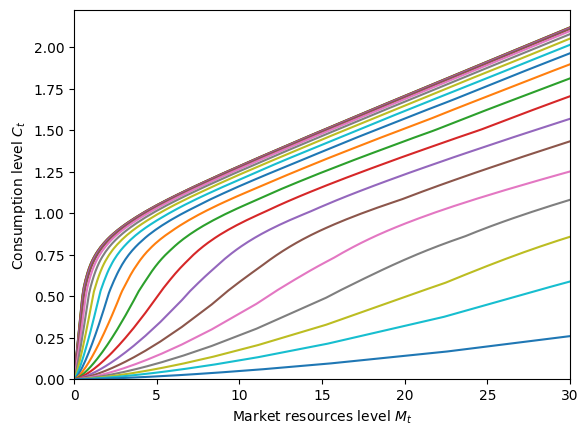

In [4]:
# Plot the consumption function holding permanent income fixed
M = np.linspace(0, 30, 300)
pLvl = 1.0
P = pLvl * np.ones_like(M)
for j in range(MedicalExample.MedShkDstn[0].pmv.size):
    MedShk = MedicalExample.MedShkDstn[0].atoms.flatten()[j] * np.ones_like(M)
    M_temp = M + MedicalExample.solution[0].mLvlMin(pLvl)
    C = MedicalExample.solution[0].cFunc(M_temp, P, MedShk)
    plt.plot(M_temp, C)
print(r"Consumption function by medical need shock (constant permanent income P = 1)")
plt.xlim(0.0, 30.0)
plt.ylim(0.0, None)
plt.xlabel(r"Market resources level $M_t$")
plt.ylabel(r"Consumption level $C_t$")
plt.show()

Consumption function by permanent income (constant medical needs shock eta = 2)


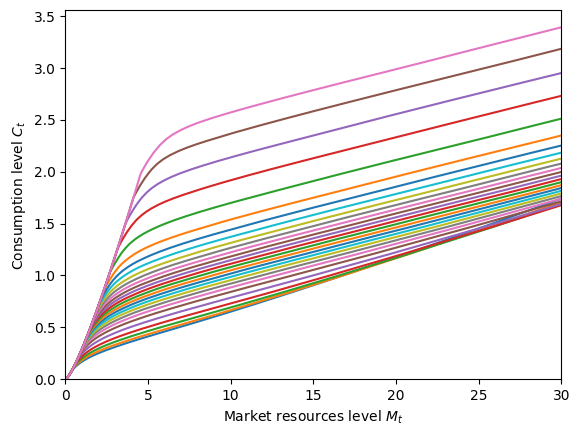

In [5]:
# Plot the consumption function holding medical needs shock fixed
eta = 2
MedShk = eta * np.ones_like(M)
for j in range(1, MedicalExample.pLvlGrid[0].size):
    P = MedicalExample.pLvlGrid[0][j] * np.ones_like(M)
    M_temp = M + MedicalExample.solution[0].mLvlMin(pLvl)
    C = MedicalExample.solution[0].cFunc(M_temp, P, MedShk)
    plt.plot(M_temp, C)
print(
    r"Consumption function by permanent income (constant medical needs shock eta = 2)"
)
plt.xlim(0.0, 30.0)
plt.ylim(0.0, None)
plt.xlabel(r"Market resources level $M_t$")
plt.ylabel(r"Consumption level $C_t$")
plt.show()

Medical care function by medical need shock (constant permanent income P = 1)


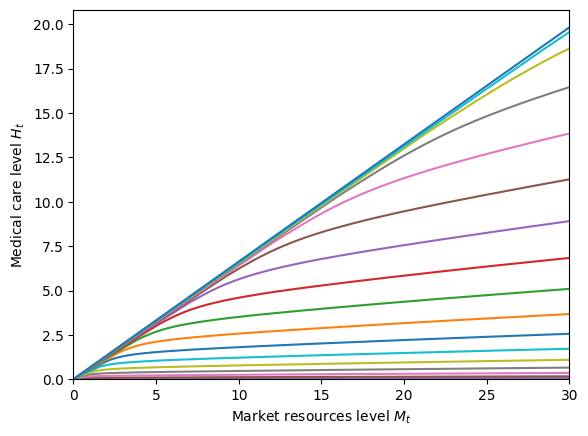

In [6]:
# Plot the medical care function holding permanent income fixed
M = np.linspace(0, 30, 300)
pLvl = 1.0
P = pLvl * np.ones_like(M)
for j in range(MedicalExample.MedShkDstn[0].pmv.size):
    MedShk = MedicalExample.MedShkDstn[0].atoms.flatten()[j] * np.ones_like(M)
    M_temp = M + MedicalExample.solution[0].mLvlMin(pLvl)
    Med = MedicalExample.solution[0].MedFunc(M_temp, P, MedShk)
    plt.plot(M_temp, Med)
print(r"Medical care function by medical need shock (constant permanent income P = 1)")
plt.xlim(0.0, 30.0)
plt.ylim(0.0, None)
plt.xlabel(r"Market resources level $M_t$")
plt.ylabel(r"Medical care level $H_t$")
plt.show()

Medical care function by permanent income (constant medical needs shock eta = 2)


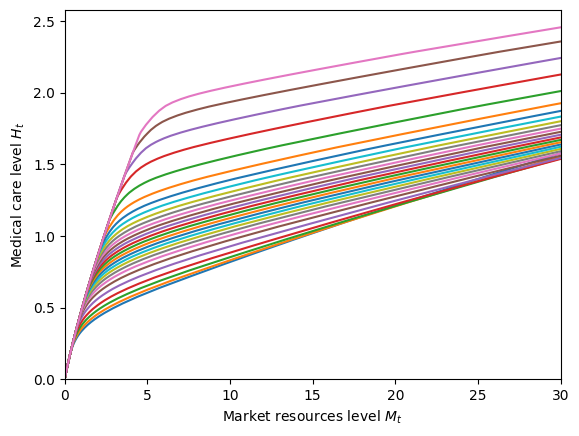

In [7]:
# Plot the medical care function holding medical needs shock fixed
eta = 2
MedShk = eta * np.ones_like(M)
for j in range(1, MedicalExample.pLvlGrid[0].size):
    P = MedicalExample.pLvlGrid[0][j] * np.ones_like(M)
    M_temp = M + MedicalExample.solution[0].mLvlMin(pLvl)
    Med = MedicalExample.solution[0].MedFunc(M_temp, P, MedShk)
    plt.plot(M_temp, Med)
print(
    r"Medical care function by permanent income (constant medical needs shock eta = 2)"
)
plt.xlim(0.0, 30.0)
plt.ylim(0.0, None)
plt.xlabel(r"Market resources level $M_t$")
plt.ylabel(r"Medical care level $H_t$")
plt.show()

Marginal value function (pseudo inverse)


C:\Users\Matthew\Documents\GitHub\HARK\HARK\rewards.py:66: RuntimeWarning: divide by zero encountered in power
  return c**-rho


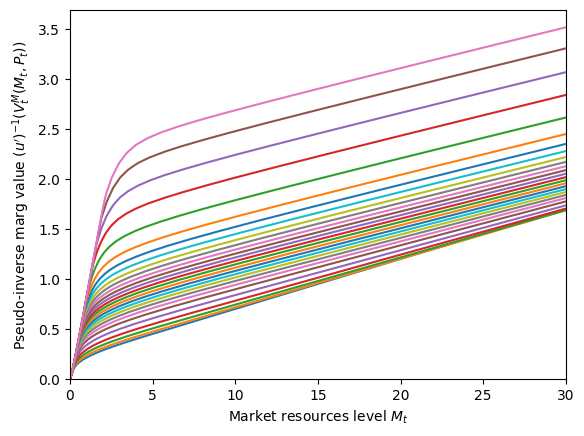

In [8]:
# Plot the marginal value function (expectation after income shocks but before medical needs shock)
M = np.linspace(0.0, 30, 300)
for p in range(1, MedicalExample.pLvlGrid[0].size):
    pLvl = MedicalExample.pLvlGrid[0][p]
    P = pLvl * np.ones_like(M)
    vP = MedicalExample.solution[0].vPfunc(M, P) ** (-1.0 / MedicalExample.CRRA)
    plt.plot(M_temp, vP)
print("Marginal value function (pseudo inverse)")
plt.xlim(0.0, 30.0)
plt.ylim(0.0, None)
plt.xlabel(r"Market resources level $M_t$")
plt.ylabel(r"Pseudo-inverse marg value $(u')^{-1}(V_t^M(M_t,P_t))$")
plt.show()

Value function (pseudo inverse)


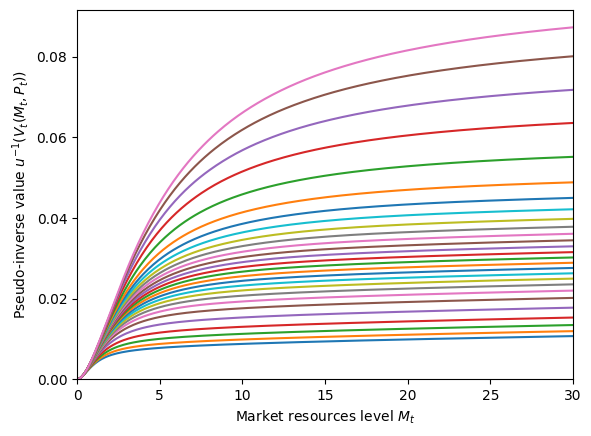

In [9]:
if MedicalExample.vFuncBool:
    # Plot the value function (expectation after income shocks but before medical needs)
    M = np.linspace(0.0, 1, 300)
    for p in range(1, MedicalExample.pLvlGrid[0].size):
        pLvl = MedicalExample.pLvlGrid[0][p]
        P = pLvl * np.ones_like(M)
        v = CRRAutility_inv(
            MedicalExample.solution[0].vFunc(M, P),
            MedicalExample.CRRA,
        )
        plt.plot(M_temp, v)
    print("Value function (pseudo inverse)")
    plt.xlim(0.0, 30.0)
    plt.ylim(0.0, None)
    plt.xlabel(r"Market resources level $M_t$")
    plt.ylabel(r"Pseudo-inverse value $u^{-1}(V_t(M_t,P_t))$")
    plt.show()

In [10]:
if do_simulation:
    t_start = time()
    MedicalExample.T_sim = 100
    MedicalExample.track_vars = ["aLvl", "cLvl", "Med"]
    MedicalExample.initialize_sim()
    MedicalExample.simulate()
    t_end = time()
    print(
        "Simulating "
        + str(MedicalExample.AgentCount)
        + " agents for "
        + str(MedicalExample.T_sim)
        + " periods took "
        + mystr(t_end - t_start)
        + " seconds.",
    )

Simulating 10000 agents for 100 periods took 6.3035 seconds.


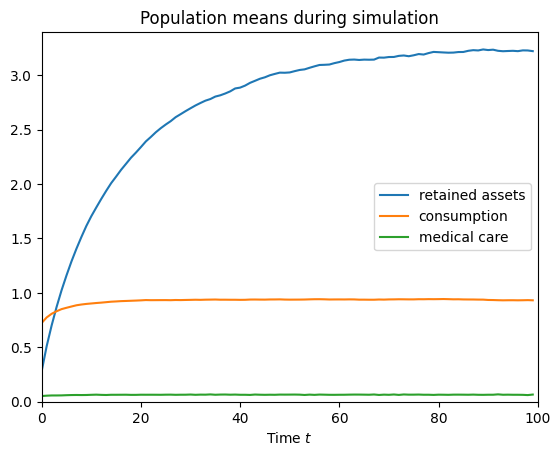

In [11]:
if do_simulation:
    plt.plot(np.mean(MedicalExample.history["aLvl"], axis=1), label="retained assets")
    plt.plot(np.mean(MedicalExample.history["cLvl"], axis=1), label="consumption")
    plt.plot(np.mean(MedicalExample.history["Med"], axis=1), label="medical care")
    plt.legend()
    plt.xlim(0.0, MedicalExample.T_sim)
    plt.ylim(0.0, None)
    plt.title("Population means during simulation")
    plt.xlabel(r"Time $t$")
    plt.show()